In [0]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [0]:
# read the dataset
X = pd.read_csv('/content/X_data.csv',index_col=0)
y_df = pd.read_csv('/content/y_data.csv',index_col=0)
y = y_df['y']

In [5]:
# plot the head of varables
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [6]:
# plot the head of target
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

In [0]:
# split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.75, 
                                                    random_state=0)

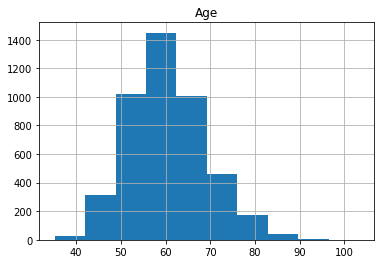

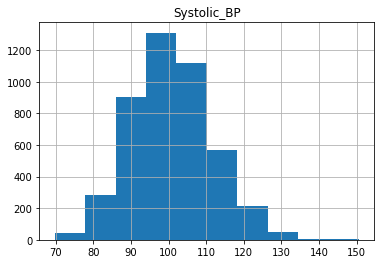

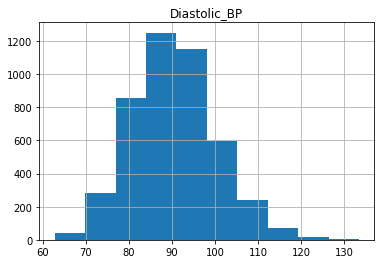

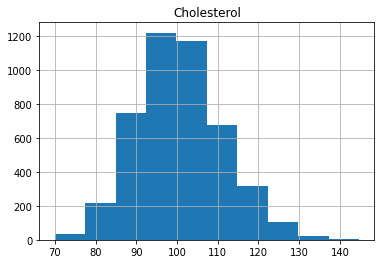

In [8]:
# plot histogram of all the columns of the variables
for col in X.columns:
    X_train.loc[:, col].hist()
    plt.title(col)
    plt.show()

In [0]:
# function to normalize the dataset
def normalize(train, test):
    # remove the skew by using the log value of the data
    train_unskewed = np.log(train)
    test_unskewed = np.log(test)

    # calculate the mean and the standard deviation of 
    # the training data
    mean = np.mean(train_unskewed, axis=0)
    stdev = train_unskewed.std(ddof=1)

    # normalize the train and test datasets
    train_norm = (train_unskewed - mean) / stdev
    teat_norm = (test_unskewed - mean) / stdev

    return train_norm, test_norm

In [0]:
# normalize the dataset
X_train, X_test = normalize(X_train, X_test)

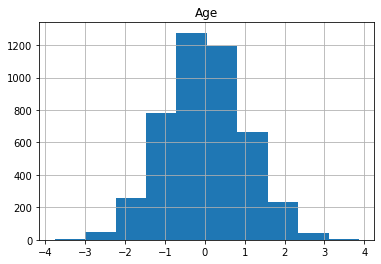

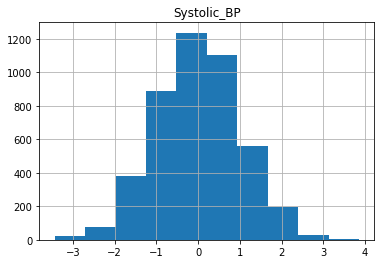

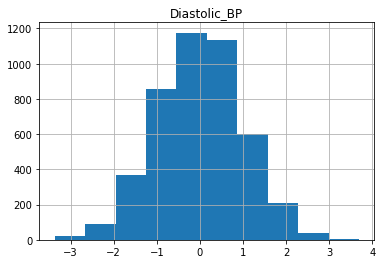

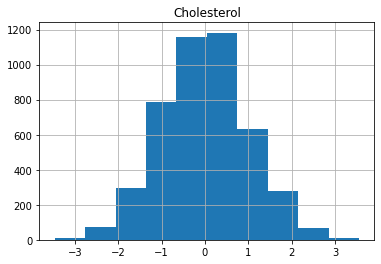

In [11]:
# plot the histograms after normalizing the dataset
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

In [0]:
# function to calculate the C-Index
def cIndex(y, scores):
    concordant = 0
    permissible = 0
    ties = 0

    for i in range(len(y)):
        for j in range(i+1, len(y)):

            # check if permissible
            if y[i] != y[j]:
                permissible += 1

                # check for ties
                if scores[i] == scores[j]:
                    ties += 1
                    continue
                
                # case 1: 
                #   patient i doesn't get the disease,
                #   patient j does
                if y[i] == 0 and y[j] == 1:
                    # concordant: check if i has lower score
                    if scores[i] < scores[j]:
                        concordant += 1
                
                # case 2: 
                #   patient i gets the disease,
                #   patient j doesn't
                if y[i] == 1 and y[j] == 0:
                    # concordant: check if i has higher score
                    if scores[i] > scores[j]:
                        concordant += 1

    # calculate the C-Index
    c_index = (concordant + 0.5 * ties) / permissible

    return c_index

In [0]:
# function to add interactions to the dataset
def interactions(X):
    # create a copy of the dataset
    X_int = X.copy(deep=True)

    for i in range(len(X.columns)):
        # get name and data for ith feature
        feature_i_name = X.columns[i]
        feature_i_data = X[feature_i_name]

        for j in range(i+1, len(X.columns)):
            # get name and data for jth feature
            feature_j_name = X.columns[j]
            feature_j_data = X[feature_j_name]

            # create a new name for the interaction column
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"

            # calculate the data for the interaction column
            X_int[feature_i_j_name] = feature_i_data * feature_j_data
    
    return X_int

In [0]:
# add interactions to the train and test dataset
X_train = interactions(X_train)
X_test = interactions(X_test)

In [15]:
# check the columns after adding interaction features
X_train.columns

Index(['Age', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol',
       'Age_x_Systolic_BP', 'Age_x_Diastolic_BP', 'Age_x_Cholesterol',
       'Systolic_BP_x_Diastolic_BP', 'Systolic_BP_x_Cholesterol',
       'Diastolic_BP_x_Cholesterol'],
      dtype='object')

In [16]:
# create a model and fit the dataset
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
# evaluate the model
predictions = model.predict_proba(X_test)[:, 1]
c_index = cIndex(y_test.values, predictions)

print(c_index)

0.8281427779041984


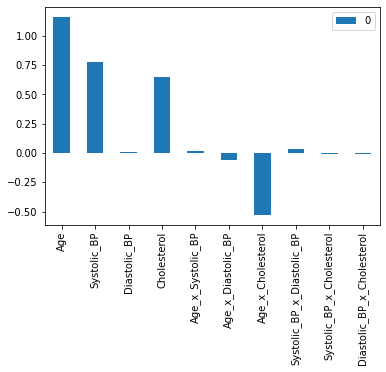

In [18]:
# plot the coefficients of the features
int_coeffs = pd.DataFrame(data = model.coef_, columns = X_train.columns)
int_coeffs.T.plot.bar();

In [27]:
# get the list of columns with small coefficients
dropColumns = []

for (i, coeff) in enumerate(model.coef_[0]):
    if abs(coeff) < 0.05:
        dropColumns.append(X_train.columns[i])

dropColumns

['Age_x_Systolic_BP', 'Systolic_BP_x_Diastolic_BP']

In [0]:
# drop the columns with small coefficients
X_train = X_train.drop(dropColumns, axis=1)
X_test = X_test.drop(dropColumns, axis=1)

In [29]:
# create a new model and fit the dataset
model_new = LogisticRegression()
model_new.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# evaluate the new model
predictions = model_new.predict_proba(X_test)[:, 1]
c_index = cIndex(y_test.values, predictions)

print(c_index)

0.8285623364432814


In [32]:
# New set of attributes
X_train.columns

Index(['Age', 'Systolic_BP', 'Cholesterol', 'Age_x_Diastolic_BP',
       'Age_x_Cholesterol'],
      dtype='object')